# Setup

In [175]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
from IPython.display import Image

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine import imputation
from feature_engine import encoding
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropFeatures
from sklearn.preprocessing import LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from skopt import BayesSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
#importing data
data = pd.read_csv(r'C:\Users\franc\Data Science\Notebooks\fraud-modeling\data\data.csv')

In [3]:
data.head(2)

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0


In [4]:
data['categoria_produto'].value_counts() 

cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
               ... 
cat_0d1c81b       1
cat_4fc8b8b       1
cat_9ba475f       1
cat_75e1eaf       1
cat_45b507c       1
Name: categoria_produto, Length: 8324, dtype: int64

# Exploratory Data Analysis (EDA)

Primeiro vamos olhar para algumas estatísticas das nossas features

In [5]:
data.describe()

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,entrega_doc_1,valor_compra,score_fraude_modelo,fraude
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,43.523134,48.066240,0.050000
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,91.557888,28.995122,0.217946
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,9.380000,23.000000,0.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,20.610000,48.000000,0.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,40.692500,73.000000,0.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,3696.350000,100.000000,1.000000


Agora, iremos observar os dados faltantes

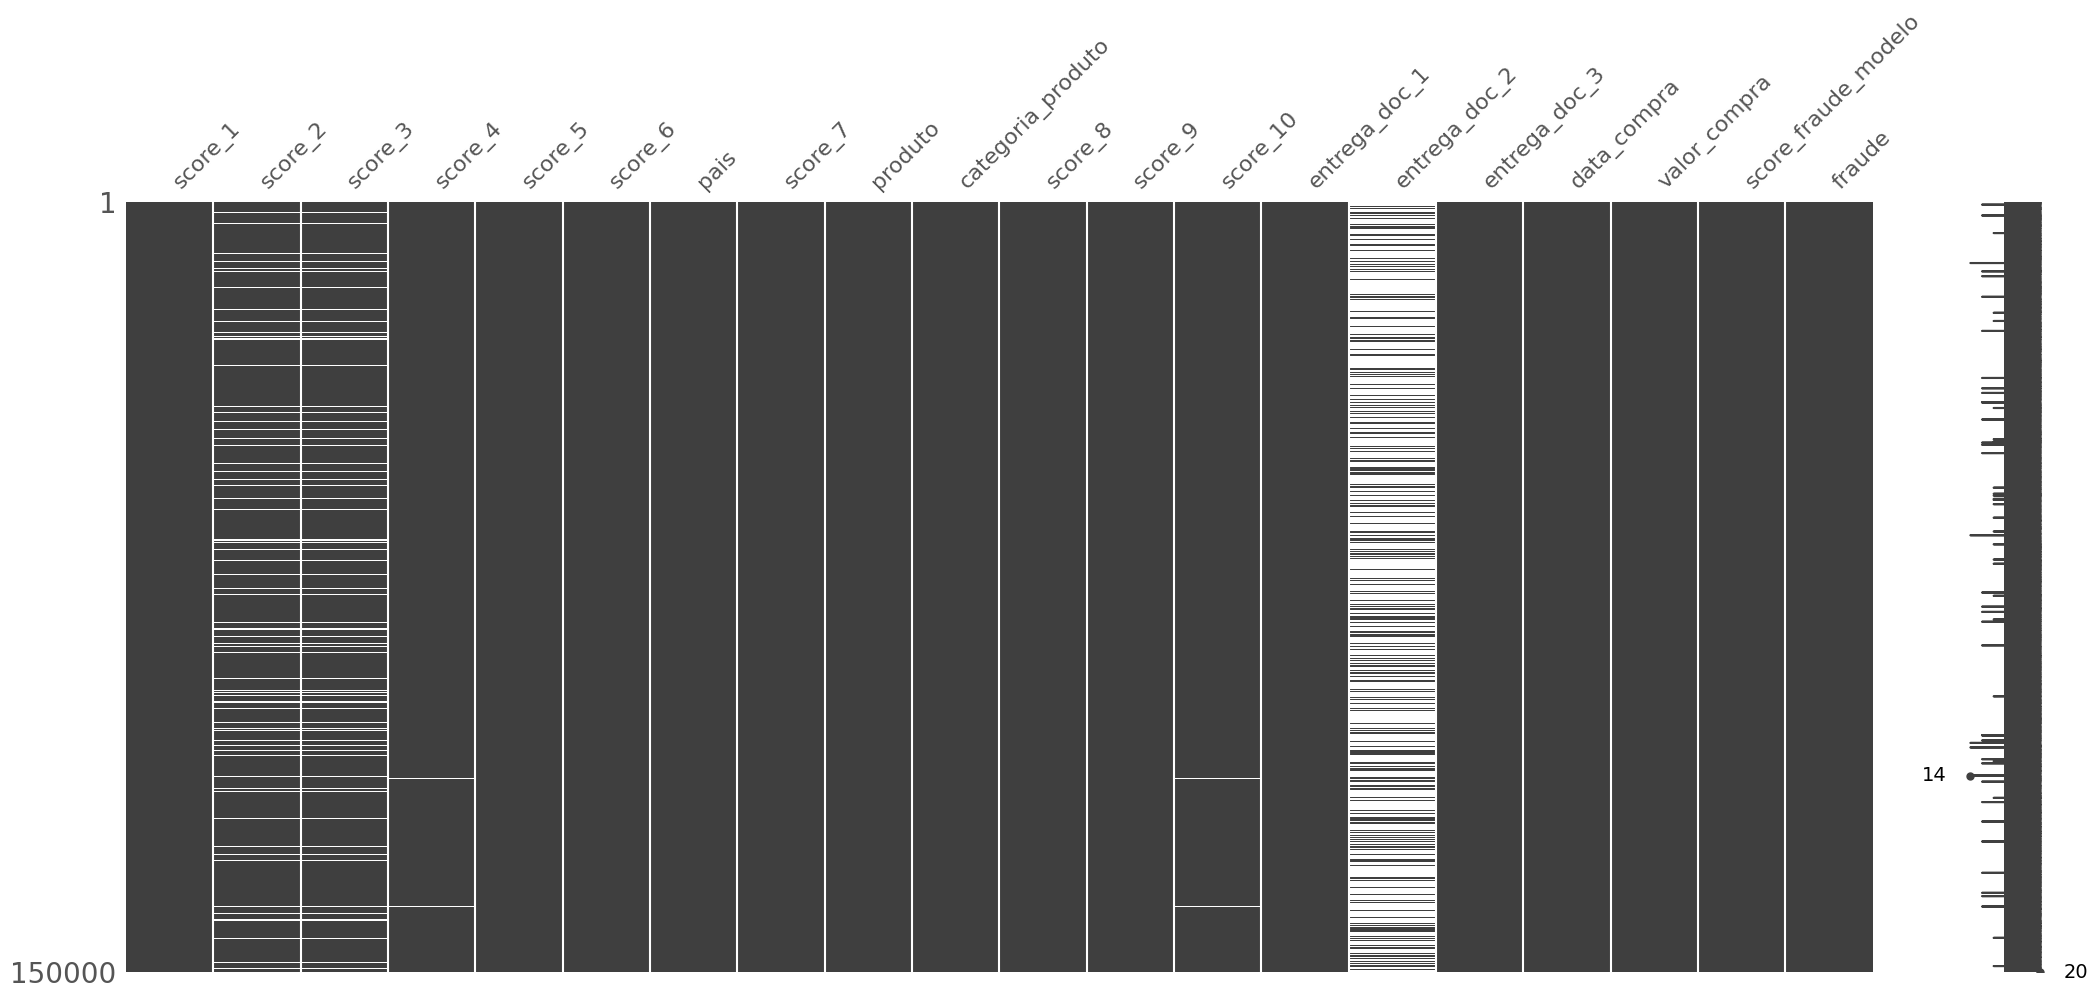

In [6]:
msno.matrix(data);

Podemos observar um numero elevado de valores missing na feature entrega_doc_2. também há um valor considerável nas features score_2 e score_3.

Devemos nos preocupar em como tratar esses valores. Entretanto, iremos fazer isso após realizar a divisão dos nossos dados, para evitar vazamento de dados.

## Análise univariada

Primeiro, vamos analisar a proporção de fraude no nosso dataset.

In [7]:
palette = ["#2ab613", "#ff1100"]

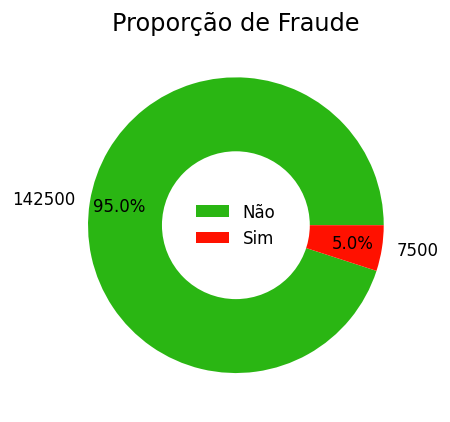

In [8]:
donut = data["fraude"].value_counts().reset_index()

labels = ["Não", "Sim"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["fraude"],
        labels=donut["fraude"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode, colors= palette)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Proporção de Fraude")
plt.legend(labels, loc="center", frameon=False)
plt.show();

Podemos observar que temos um caso de target rara. Apenas 5% dos casos ocorrem fraudes.

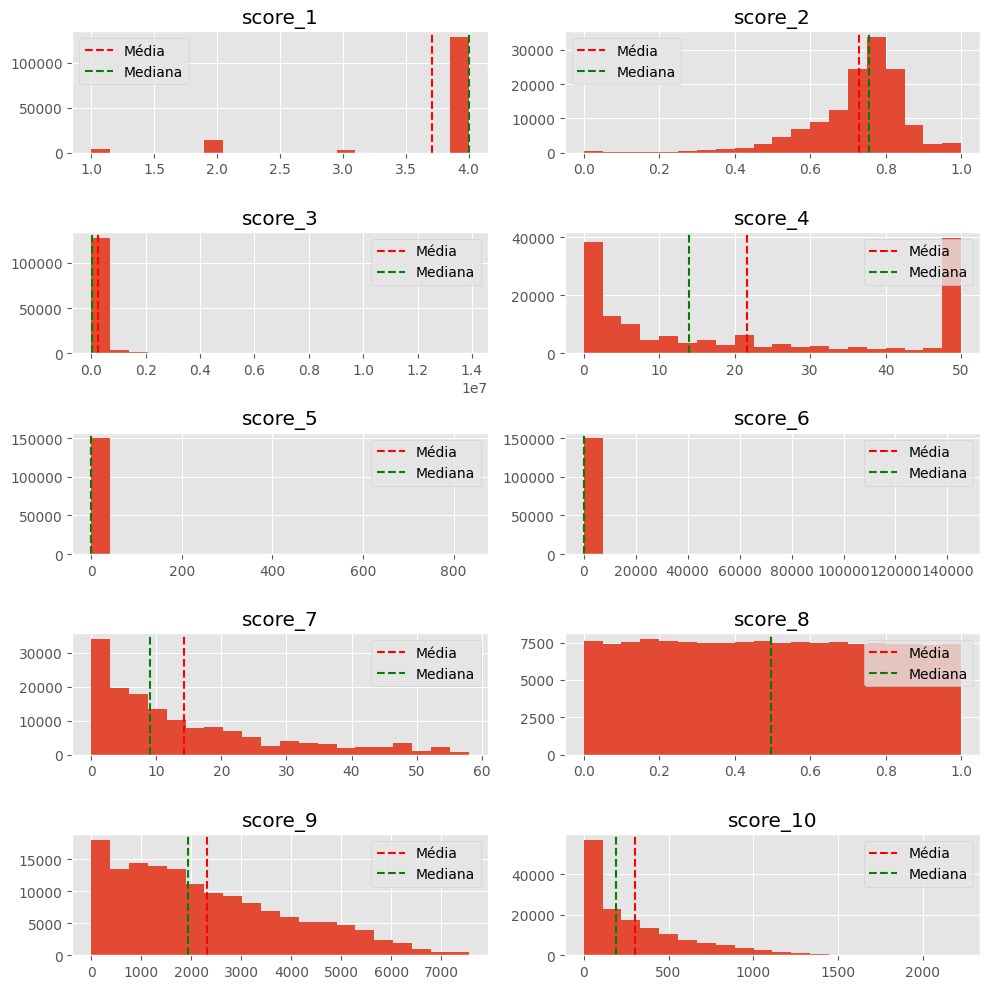

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

cols = ["score_1", "score_2", "score_3", "score_4", 'score_5',
        'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

# Loop para plotar os histogramas em cada subplot
for i, ax in enumerate(axes.ravel()):
    if i < len(cols):
        col = cols[i]
        ax.hist(data[col], bins=20)  # Você pode ajustar o número de bins conforme necessário
        
        mean = data[col].mean()
        median = data[col].median()
        ax.axvline(mean, color='red', linestyle='--', label='Média')
        ax.axvline(median, color='green', linestyle='--', label='Mediana')
        ax.set_title(col)
        ax.legend()
plt.tight_layout()

# Exibir os gráficos
plt.show()

Podemos perceber alguns padrões de outliers nas features score_3, score_5 e score_6. Para isso, vamos analisar se realmente os dados são outliers e tratar os casos.

In [10]:
percentiles = [10,  20,  30,  40,  50,  60,  70,  80, 85, 90, 95, 99, 100]
scores = ['score_3', 'score_5', 'score_6']

for score in scores:
    for percentil in percentiles:
        print(f'{score} {percentil}% = {np.percentile(data[score].dropna(), percentil).round(2)}')
    print()

score_3 10% = 1800.12
score_3 20% = 6285.86
score_3 30% = 13878.48
score_3 40% = 26123.49
score_3 50% = 43711.66
score_3 60% = 70814.5
score_3 70% = 112449.24
score_3 80% = 191395.0
score_3 85% = 270186.7
score_3 90% = 454000.63
score_3 95% = 1031954.91
score_3 99% = 4948124.06
score_3 100% = 13878743.71

score_5 10% = 0.0
score_5 20% = 0.0
score_5 30% = 0.0
score_5 40% = 0.0
score_5 50% = 0.1
score_5 60% = 0.17
score_5 70% = 0.24
score_5 80% = 0.33
score_5 85% = 0.4
score_5 90% = 0.5
score_5 95% = 0.71
score_5 99% = 1.42
score_5 100% = 833.33

score_6 10% = 0.0
score_6 20% = 1.0
score_6 30% = 2.0
score_6 40% = 4.0
score_6 50% = 8.0
score_6 60% = 14.0
score_6 70% = 25.0
score_6 80% = 44.0
score_6 85% = 62.0
score_6 90% = 92.0
score_6 95% = 162.0
score_6 99% = 483.0
score_6 100% = 145274.0



Podemos observar também a distribuição da variável valor_compra.

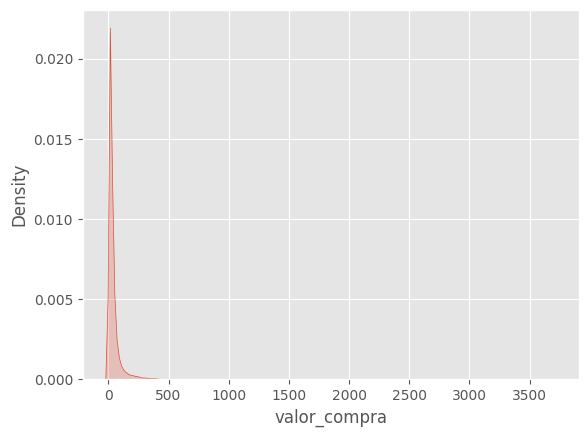

In [11]:
sns.kdeplot(data['valor_compra'], fill=True);

Observa-se uma distribuição de cauda longa. Portanto, a fim de visualizar melhor nossa distribuição, podemos plotar apenas os dados menos que o percentil 99.

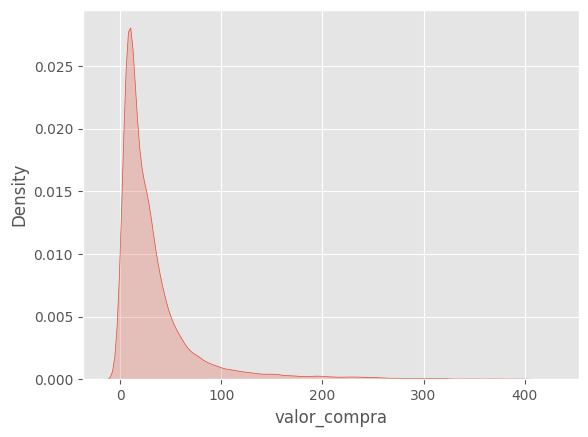

In [12]:
p99 = np.percentile(data['valor_compra'], 99)
sns.kdeplot(data['valor_compra'][data['valor_compra'] < p99], fill=True);

## Análise Multivariada

Vamos observar se o valor da compra possui alguma relação com a fraude.

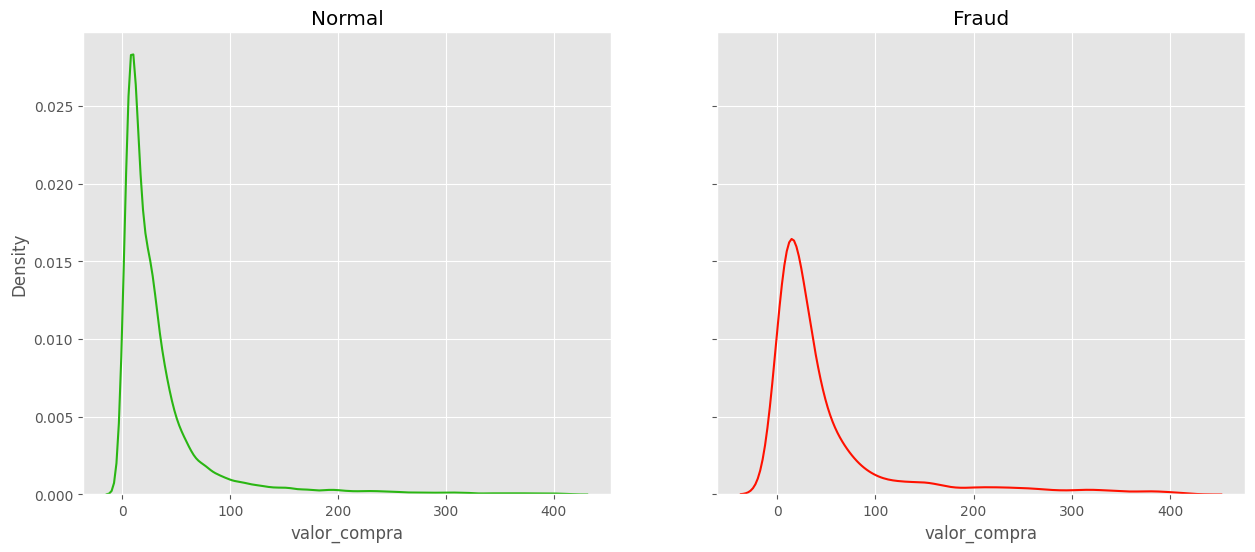

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.kdeplot(x='valor_compra', data=data[(data['valor_compra'] < p99) & (
                    data["fraude"] == 0)], ax=ax1, color=palette[0])

ax2 = sns.kdeplot(x='valor_compra', data=data[(data['valor_compra'] < p99) & (
                    data["fraude"] == 1)], ax=ax2, color=palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud");

Pode-se observar um padrão claro. Em relação ao valor da compra, operações normais possuem uma distribuição com um pico maior em valores baixos, enquanto operações com fraude são mais distribuidas ao longo de valores mais altos.

Vamos observar se a feature score_1 possui alguma relação com a target.

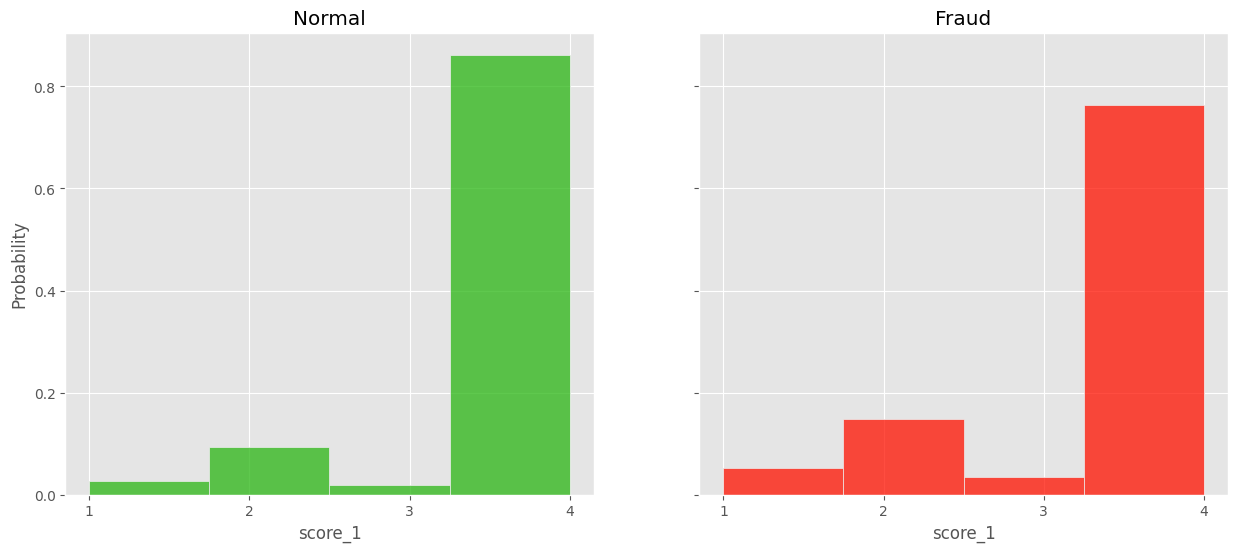

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_1', data=data[data["fraude"] == 0],
                   stat="probability", bins=4, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_1', data=data[data["fraude"] == 1],
                   stat="probability", bins=4, ax=ax2, color = palette[1])
ax1.set_xticks([1,2,3,4])
ax2.set_xticks([1,2,3,4])
ax1.set_title("Normal")
ax2.set_title("Fraud");

Há um pequeno aumento na proporção de operações normais quando o score é maior.

Agora vamos observar a mesma coisa para o resto dos scores.

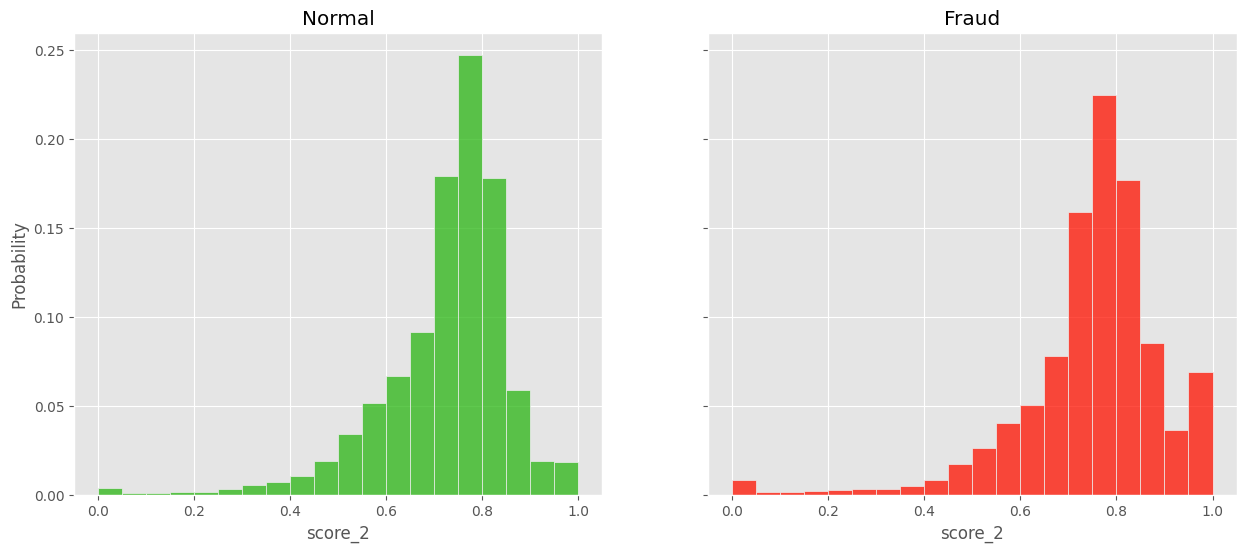

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_2', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_2', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Para o score_2, a proporção de fraude aumenta consideravelmente quando está muito próximo ou igual a 1.

Para analisarmos o score_3, podemos aplicar uma transformação logarítmica, que irá encurtar o intervalo de valores muito altos.

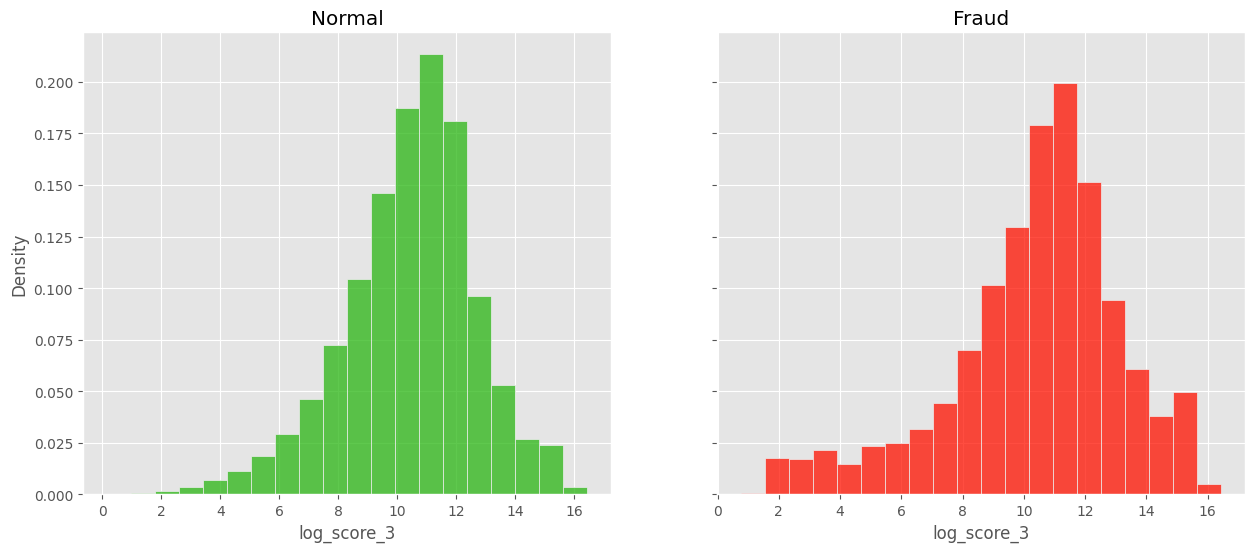

In [16]:
data['log_score_3'] = np.log1p(data['score_3'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='log_score_3', data=data[data["fraude"] == 0],
                   stat="density", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='log_score_3', data=data[data["fraude"] == 1],
                   stat="density", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Pode-se observar também um aumento na proporção de fraudes em scores mais baixos, como por exemplo de 2 até 5.

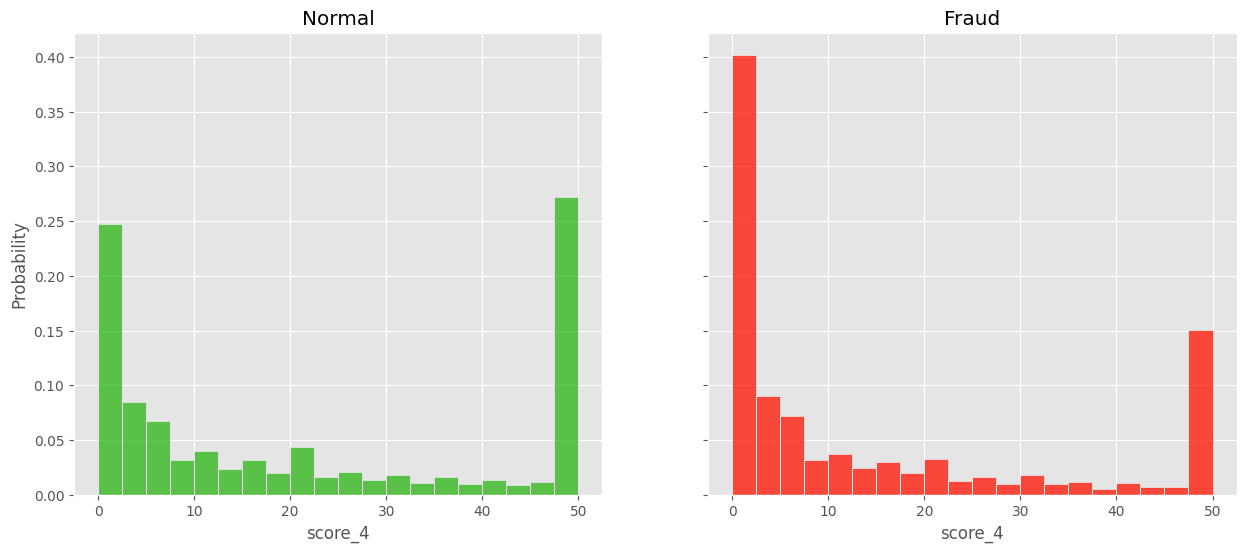

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_4', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_4', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Podemos notar que a proporção de scores próximos a 0 em casos de fraude é consideravelmente maior do que em não fraudes.

Por conta de outliers no score_5, iremos plotar apenas dados com percentis menores que 99.

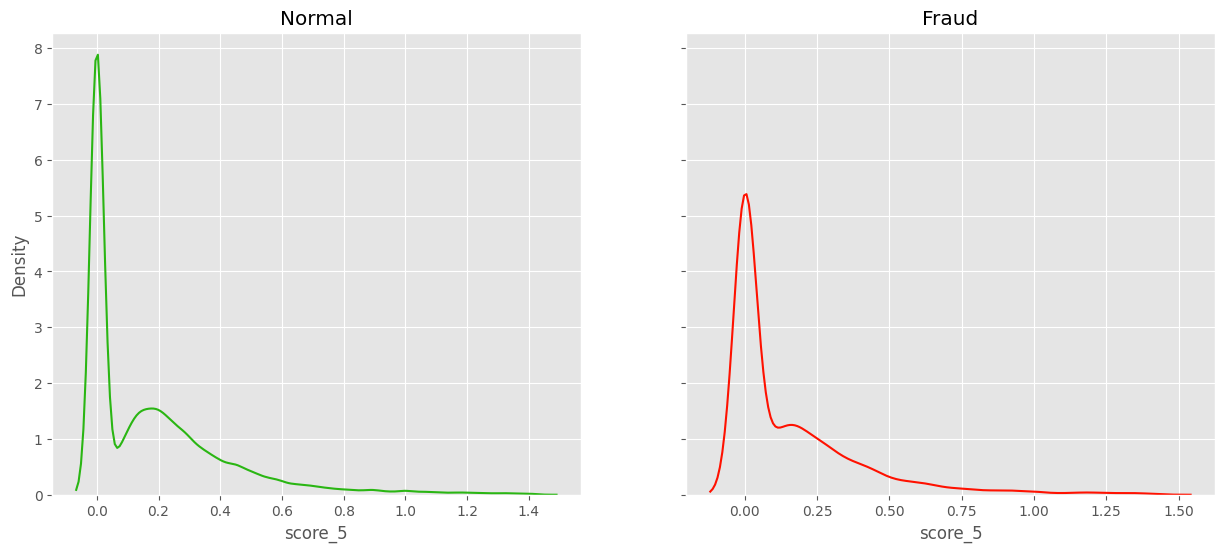

In [18]:
p99 = np.percentile(data['score_5'], 99)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.kdeplot(x='score_5', data=data[(data['score_5'] <p99) & (
                    data["fraude"] == 0)], ax=ax1, color=palette[0])

ax2 = sns.kdeplot(x='score_5', data=data[(data['score_5'] < p99) & (
                    data["fraude"] == 1)], ax=ax2, color=palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud");

Aqui podemos observar uma maior concentração em valores menores de score, para operações normais.

Realizaremos o mesmo procedimento para o score 6.

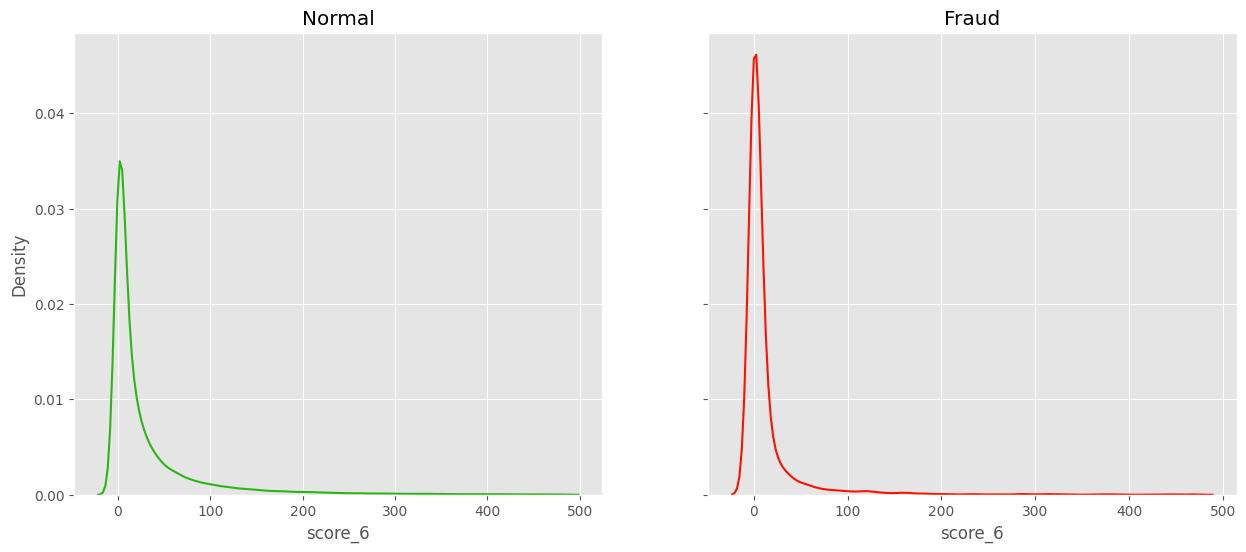

In [19]:
p99 = np.percentile(data['score_6'].dropna(), 99)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.kdeplot(x='score_6', data=data[(data['score_6'] < p99) & (
                    data["fraude"] == 0)], ax=ax1, color=palette[0])

ax2 = sns.kdeplot(x='score_6', data=data[(data['score_6'] < p99) & (
                    data["fraude"] == 1)], ax=ax2, color=palette[1])
ax1.set_title("Normal")
ax2.set_title("Fraud");

Aqui notamos o inverso, há uma maior concentração em scores próximos a 0 em operações com fraude.

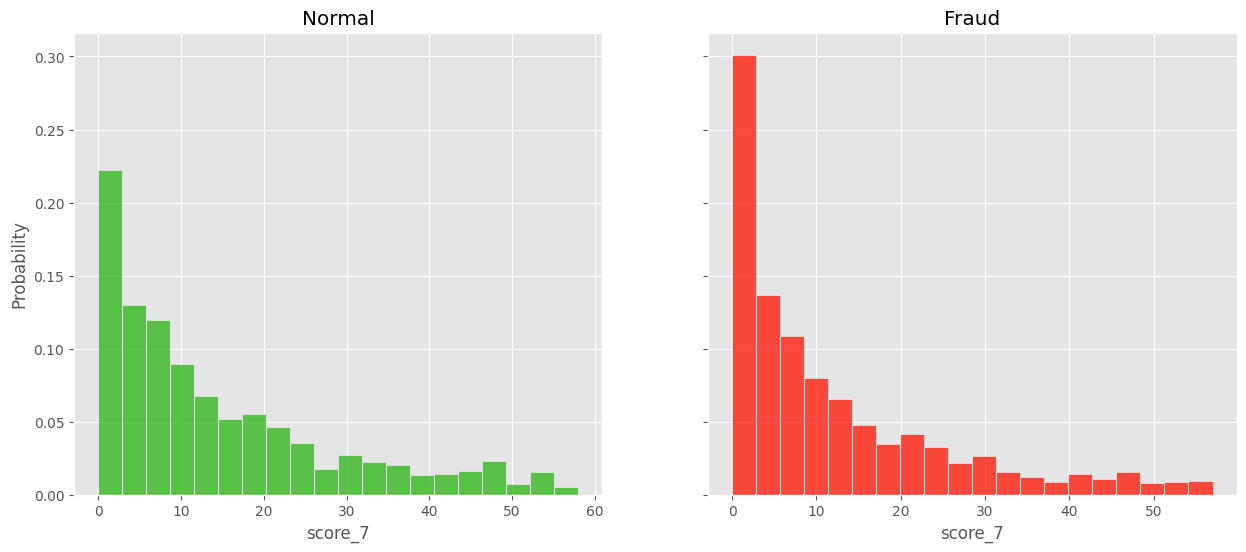

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_7', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_7', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Observa-se também uma maior concentração em scores próximo a 0 para operações com fraude.

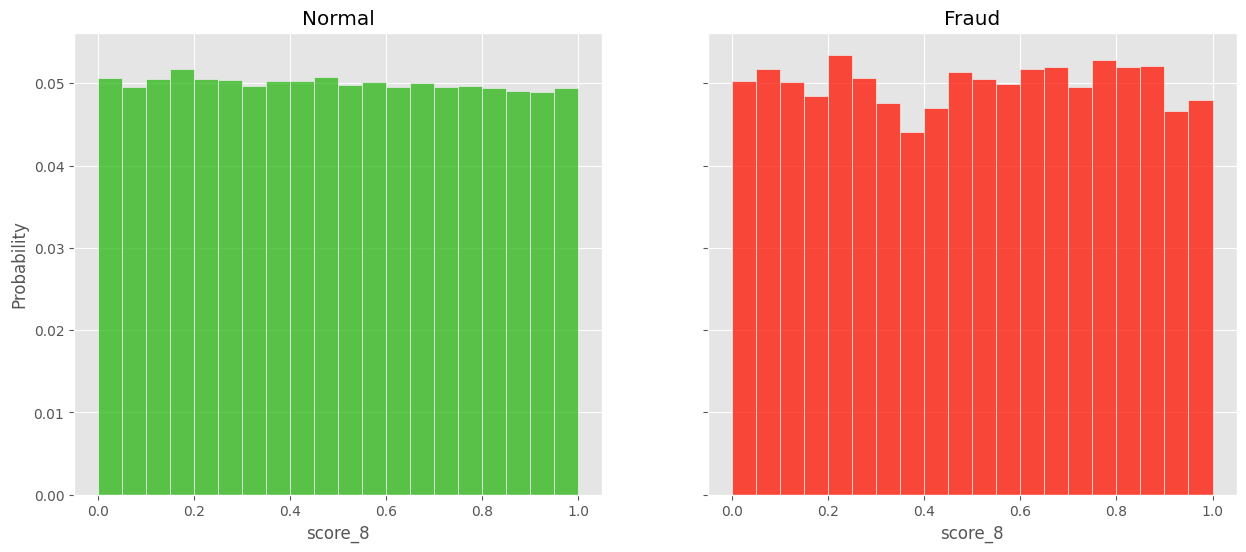

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_8', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_8', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Para o score 8, não há nenhuma evidência forte, pelo menos visualmente.

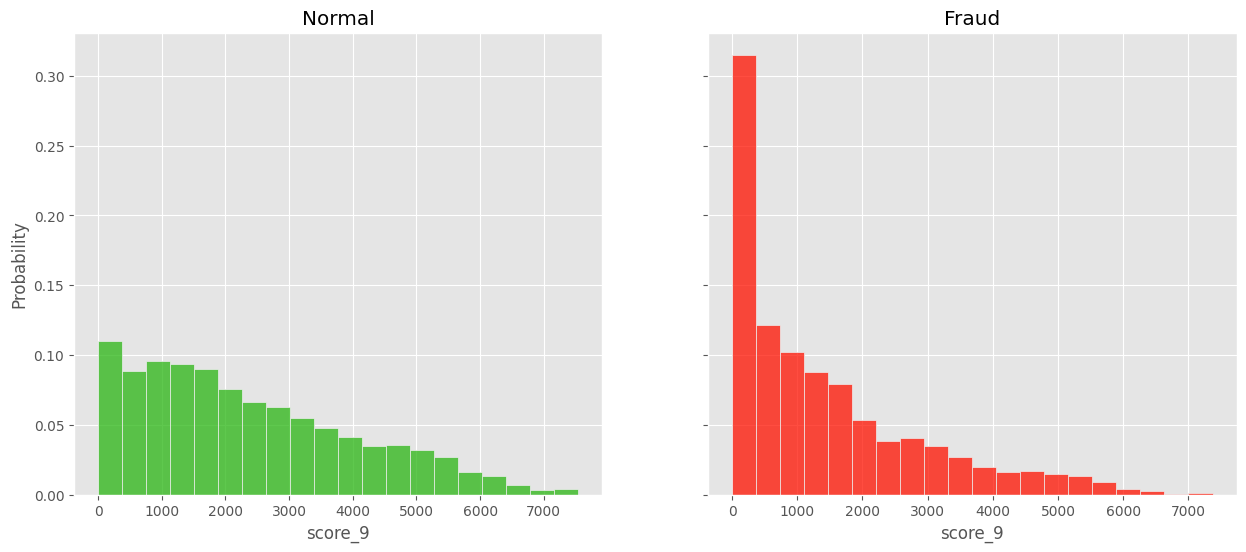

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_9', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_9', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Aqui podemos observar uma alta discrepância em scores próximos de 0 para operações fraudulentas.

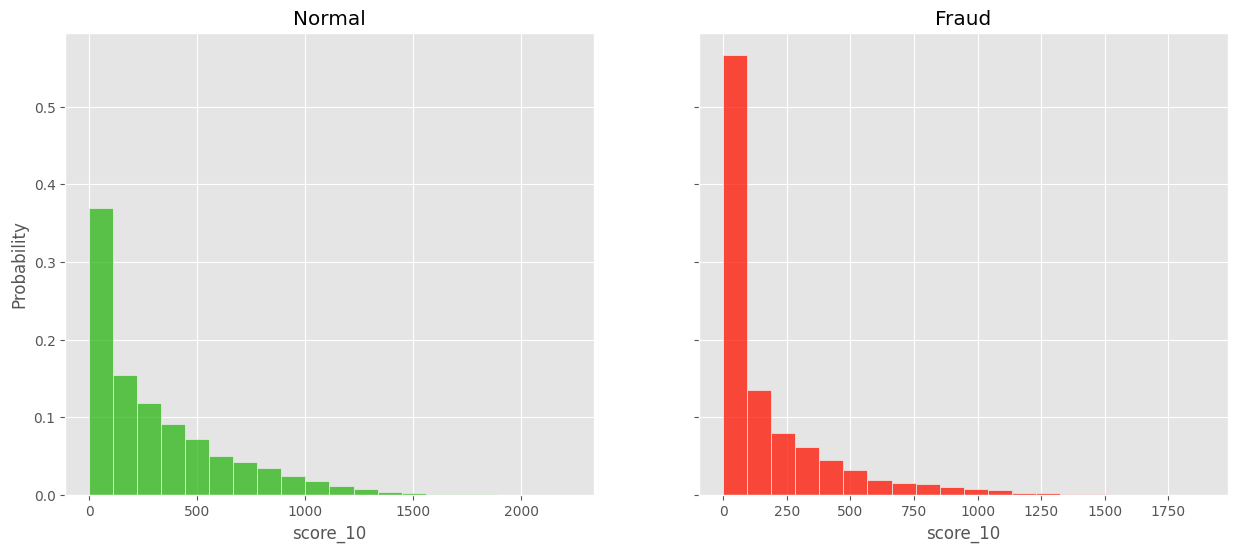

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='score_10', data=data[data["fraude"] == 0],
                   stat="probability", bins=20, ax=ax1, color = palette[0])
ax2 = sns.histplot(x='score_10', data=data[data["fraude"] == 1],
                   stat="probability", bins=20, ax=ax2, color = palette[1])

ax1.set_title("Normal")
ax2.set_title("Fraud");

Assim como o score_9, o score_10 também nota-se uma discrepância alta para scores baixos.

Também podemos analisar se o horário da compra possui alguma relação com a fraude.

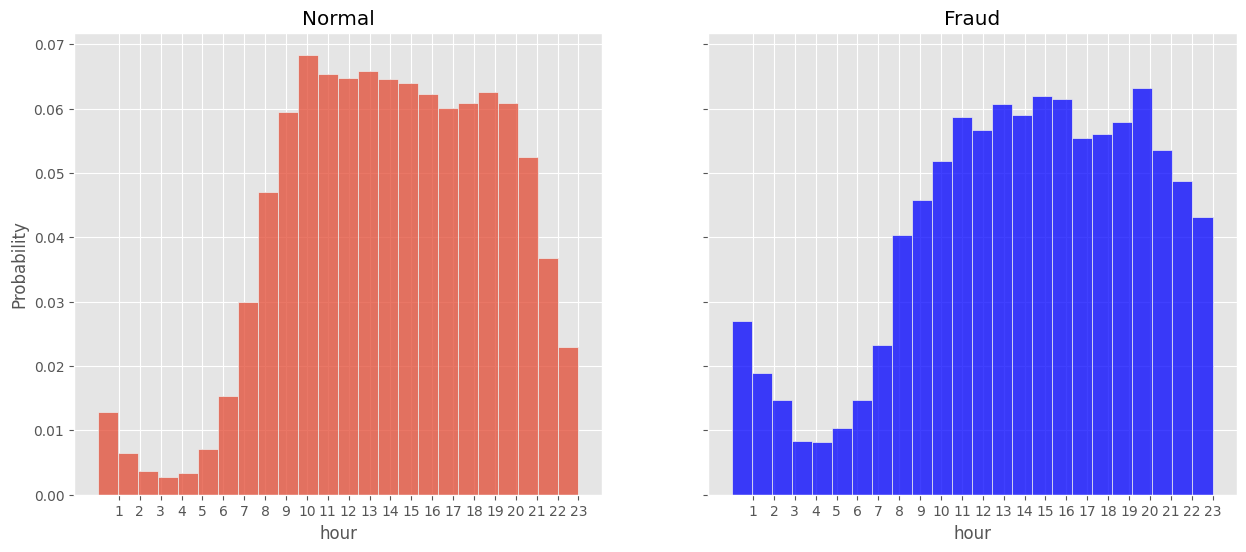

In [24]:
data['hour'] = pd.to_datetime(data['data_compra']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=data[data["fraude"] == 0],
                   stat="probability", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=data[data["fraude"] == 1],
                   stat="probability", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

In [25]:
data.drop(columns='hour', inplace=True)

Podemos notar que, em casos de fraude, a proporção de transações em horários de madrugada são maiores. Logo, será útil trazer essa feature para o nosso modelo.

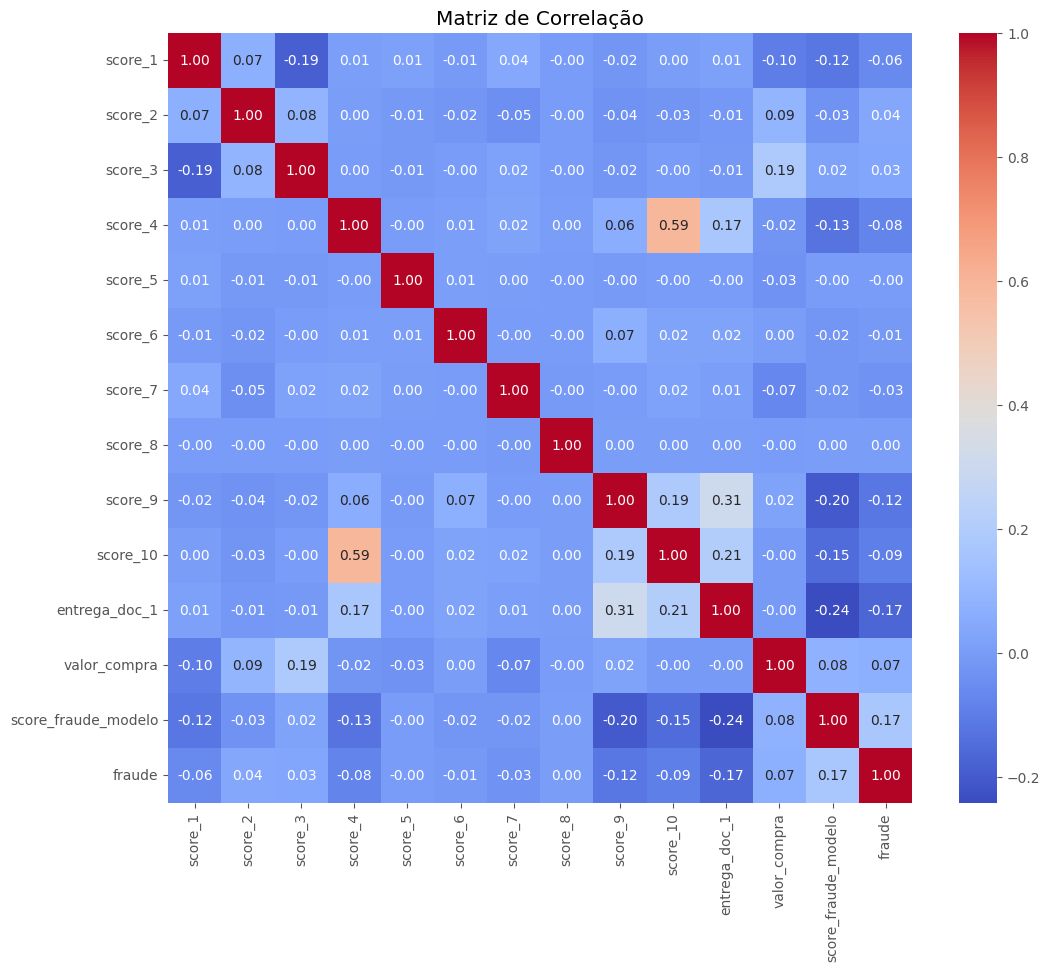

In [26]:
data.drop(columns=['log_score_3'], inplace=True)
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Matriz de Correlação")
plt.show()

# Data splitting

Vamos separar nosso dataset em treino e teste.

In [27]:
int_columns = data.select_dtypes(include=['int64']).columns
data[int_columns] = data[int_columns].astype(float)

In [28]:
X = data.drop(columns=['fraude'])
y = data['fraude']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2, stratify=y)

In [29]:
y_train.shape[0], y_test.shape[0], y_train.shape[0] + y_test.shape[0], data.shape[0]

(120000, 30000, 150000, 150000)

# Data pre-processing

## Missing Data

Devemos analisar cuidadosamente cada variável e os significados de seus valores estarem faltantes, para decidir o tipo de imputação.

In [30]:
data.isnull().sum().sort_values(ascending=False)

entrega_doc_2          108857
score_3                 12984
score_2                 12984
score_4                   365
score_10                  365
pais                      194
score_6                    11
score_9                    11
score_1                     0
score_fraude_modelo         0
valor_compra                0
data_compra                 0
entrega_doc_3               0
score_8                     0
entrega_doc_1               0
categoria_produto           0
produto                     0
score_7                     0
score_5                     0
fraude                      0
dtype: int64

Para a variável "entrega_doc_2", devemos considerar como "N" os valores faltantes, por conta da descrição do problema.

In [31]:
replace_N = ['entrega_doc_2']

Para as features de score, iremos atribuir o valor -100. Não vamos atribuir média/mediana, pois os dados que estão faltando são dados que o cliente não possui. Logo, ao atribuir a média, estamos perdendo um padrão que pode ser valioso para o modelo: não possuir o score.

In [32]:
replace_minus_100 = ['score_2', 'score_3',
                     'score_4', 'score_6',
                     'score_9', 'score_10']

Para a feature "pais", iremos atribuir o valor "x", ou seja, um valor desconhecido.

In [33]:
replace_x = ['pais']

In [34]:
imputer_N = imputation.CategoricalImputer(fill_value='N', variables=replace_N)

imputer_minus_100 = imputation.ArbitraryNumberImputer(arbitrary_number=-100,
                                                      variables=replace_minus_100)


imputer_x = imputation.CategoricalImputer(fill_value='x', variables=replace_x)

Iremos limitar os valores das features "scores_5" e "scores_6", para reduzir o efeito dos outliers.

In [35]:
outliers_cols = ['score_5', 'score_6']

cap_outliers = Winsorizer(variables=outliers_cols, capping_method='gaussian',
                         tail='right')

# Feature Engineering

In [36]:
X_train.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo
3051,4.0,NaN,NaN,10.0,0.000000,56.0,AR,40.0,Rodilleras Powerslide - Protecciones - Protect...,cat_6cd9498,0.849913,2357.0,204.0,1.0,Y,Y,2020-03-12 10:53:38,20.85,38.0
96590,4.0,0.7769,5348.29,50.0,0.000000,47.0,BR,11.0,Kit 3 Calça Moletom Adulto - Peluciada,cat_bdcf37d,0.494004,4824.0,455.0,1.0,N,Y,2020-04-18 10:18:35,29.30,82.0
88433,2.0,0.7379,41566.04,50.0,0.000000,0.0,UY,10.0,Comoda 4 Cajones Madera Maciza Linea Mexicana ...,cat_d49af8a,0.955828,541.0,538.0,1.0,NaN,Y,2020-04-05 11:01:28,126.80,14.0
86727,4.0,0.7115,50107.37,13.0,0.136101,18.0,BR,21.0,Touca De Rede Redinha Capilar Preta Pct C/ 100 Un,cat_b46f6c8,0.560703,2999.0,105.0,1.0,N,Y,2020-03-19 12:09:24,9.28,7.0
32490,4.0,0.6974,515552.76,1.0,0.000000,60.0,AR,50.0,Anteojo 3m Hermes Transparente Hc + Af + Origi...,cat_7484244,0.127541,4131.0,0.0,1.0,NaN,N,2020-04-08 20:40:09,37.22,37.0


Para as categorias "pais" e "categoria_produto", iremos usar a técnica WOE (Weight of Evidence).

In [37]:
cols_mean_encoding = ['pais', 'categoria_produto']

mean_encoder = encoding.MeanEncoder(variables=cols_mean_encoding)

Precisamos também transformar as colunas "entrega_doc_2" e "entrega_doc_3" em binárias.

In [38]:
class BinaryLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].map({'Y': 1, 'N': 0})
        return X_copy
    
columns_to_encode = ['entrega_doc_2', 'entrega_doc_3']

label_encoder = BinaryLabelEncoder(columns=columns_to_encode)

Também iremos extrair a informação de hora da coluna "data_compra"

In [39]:
date_variable = ['data_compra']

hour_extractor = DatetimeFeatures(variables=date_variable, features_to_extract=['hour'])

In [40]:
columns_to_remove = ['pais', 'produto', 'categoria_produto']

drop_features = DropFeatures(features_to_drop=columns_to_remove)

# Modeling

## Model Training

In [42]:
mlflow.set_experiment(experiment_name='fraud_modeling')
mlflow.sklearn.autolog()

In [165]:
%%capture

with mlflow.start_run(run_name='lgbm_tuned_2'):

    model = LGBMClassifier(random_state=0)

    space_lgbm = {'learning_rate': (0.5e-1, 1e-1),
                'num_leaves': (80,100),
                'min_child_samples': (140,180),
                'subsample': (0.15, 0.2),
                'colsample_bytree': (0.8, 1),
                'max_depth': (4,6)
                }

    bayes_search = BayesSearchCV(model, space_lgbm, cv=5, scoring='roc_auc',
                                 n_iter= 50, verbose=1, random_state=23)

    pipeline = Pipeline([('imputer_N', imputer_N),
                         ('imputer_minus_100', imputer_minus_100),
                         ('imputer_x', imputer_x),
                         ('cap_outliers', cap_outliers),
                         ('mean_encoding', mean_encoder),
                         ('label_encoder', label_encoder),
                         ('hour_extractor', hour_extractor),
                         ('drop_features', drop_features),
                         ('model', bayes_search)
                        ])
    
    pipeline.fit(X_train, y_train)
    
    #metricas de treino
    y_train_pred = pipeline.predict(X_train)
    y_train_score = pipeline.predict_proba(X_train)[:, 1]

    train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    train_precision = metrics.precision_score(y_train, y_train_pred)
    train_recall = metrics.recall_score(y_train, y_train_pred)
    train_f1_score = metrics.f1_score(y_train, y_train_pred)
    train_auc = metrics.roc_auc_score(y_train, y_train_score)
    train_log_loss = metrics.log_loss(y_train, y_train_score)
    
    #metricas de teste
    y_test_pred = pipeline.predict(X_test)
    y_test_score = pipeline.predict_proba(X_test)[:, 1]
    
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    test_precision = metrics.precision_score(y_test, y_test_pred)
    test_recall = metrics.recall_score(y_test, y_test_pred)
    test_f1_score = metrics.f1_score(y_test, y_test_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_score)
    test_log_loss = metrics.log_loss(y_test, y_test_score)

    #shift
    accuracy_shift = train_accuracy - test_accuracy
    auc_shift = train_auc - test_auc
    
    model_metrics = {"accuracy_train": train_accuracy,
                    "accuracy_test": test_accuracy,
                    "accuracy_shift": accuracy_shift,
                    "precision_train": train_precision,
                    "precision_test": test_precision,
                    "recall_train": train_recall,
                    "recall_test": test_recall,
                    "f1_score_train": train_f1_score,
                    "f1_score_test": test_f1_score,
                    "auc_train": train_auc,
                    "auc_test": test_auc,
                    "auc_shift": auc_shift,
                    "log_loss_train": train_log_loss,
                    "log_loss_test": test_log_loss
                    }
    
    mlflow.log_metrics(model_metrics)
    mlflow.sklearn.log_model(model, "xgboost")

Resultados dos testes de modelos no MLflow:

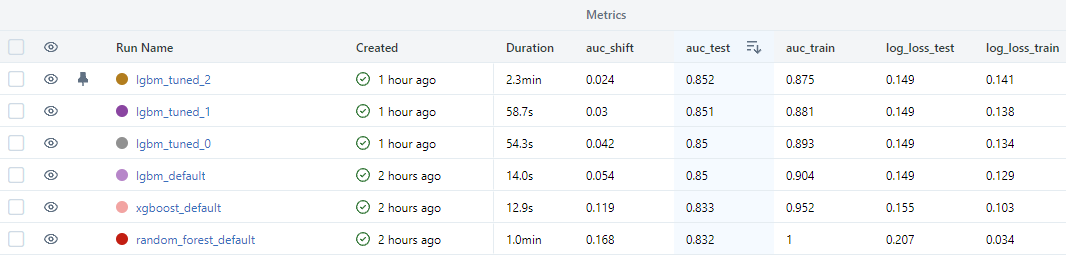

In [176]:
Image(filename='mlflow_results.png', width=2000)

Com isso, iremos usar o modelo "lgbm_tuned_2", que, além de nos dar uma performance de AUC muito boa, nos traz um shift excelente. Isso quer dizer que o modelo é generalista.

In [71]:
lgbm_best_params = bayes_search.best_params_

## Otimização do ponto de corte

Para otimizar o ponto de corte (limiar), devemos considerar o custo que um falso positivo gera para a empresa, e o custo que um falso negativo gera para a empresa. Nesse problema, um falso positivo gera um custo de 10% do valor da transação, enquanto um falso negativo acarreta na perda de 100% do valor da transação.

In [138]:
valor_compra = X_train['valor_compra'].values

thresholds = np.linspace(0, 1, num=100)

roc_auc = roc_auc_score(y_train, y_train_pred)

best_threshold = 0
min_value = float('inf')

for threshold in thresholds:

    false_positive_cost = (y_train_score >= threshold) & (y_train == 0)
    false_negative_cost = (y_train_score < threshold) & (y_train == 1)

    total_cost = np.sum(0.1 * false_positive_cost) + np.sum(false_negative_cost)

    if total_cost < min_value:
        min_value = total_cost
        best_threshold = threshold

print("Ponto de corte que minimiza o custo:", best_threshold)
print("Custo mínimo:", total_cost)

Ponto de corte que minimiza o custo: 0.09090909090909091
Custo mínimo: 6000.0


# Model Evaluation

Vamos criar uma função que calcule as principais métricas e nos mostre a matriz de confusão do modelo.

In [143]:
def evaluate_model(target, y_score, threshold = 0.5, normalize_matrix= None):
    predicted = y_score >= threshold
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = metrics.f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    false_positive_cost = (y_score >= threshold) & (target == 0)
    false_negative_cost = (y_score < threshold) & (target == 1)
    total_cost = np.sum(0.1 * false_positive_cost) + np.sum(false_negative_cost)
    
    fpr, tpr, threshold = metrics.roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    print("Total cost:", total_cost)
    return None

Avaliando os resultados para um threshold padrão (0.5):

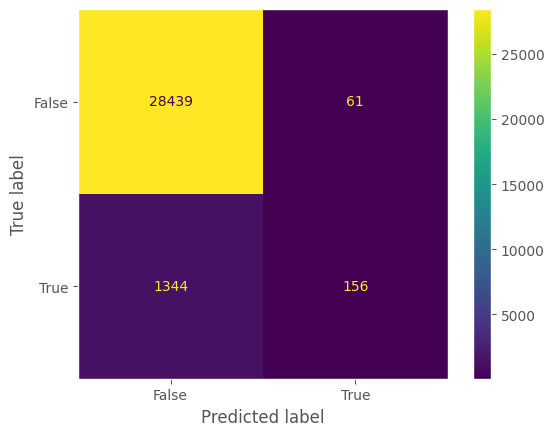

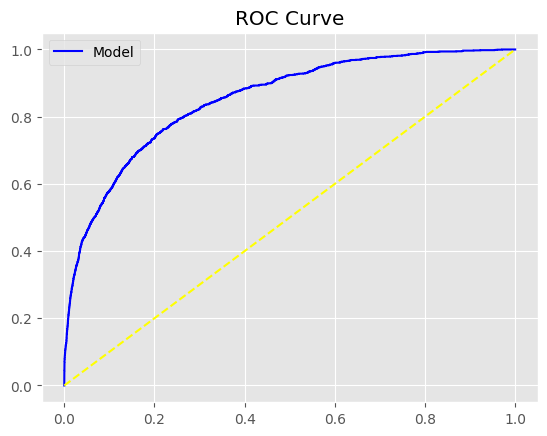

Accuracy 0.95
Precision: 0.72
Recall: 0.1
F1 Score 0.18
AUC: 0.8515478830409356
Total cost: 1350.1


In [144]:
evaluate_model(y_test, y_test_score)

Agora iremos avaliar o modelo considerando o ponto ótimo de corte!

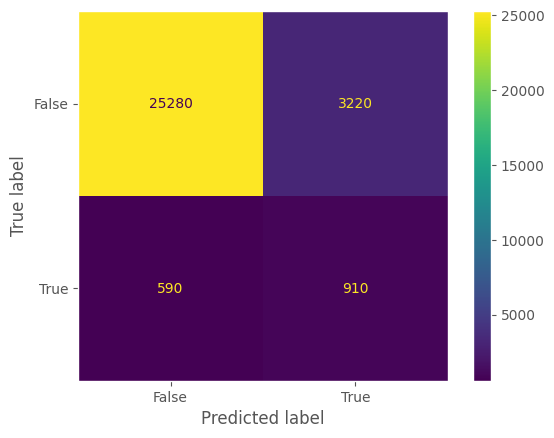

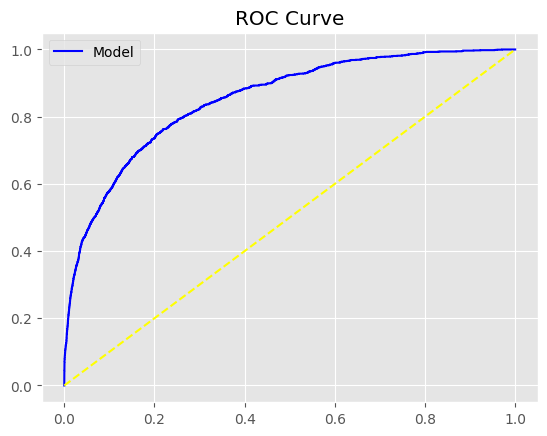

Accuracy 0.87
Precision: 0.22
Recall: 0.61
F1 Score 0.32
AUC: 0.8515478830409356
Total cost: 912.0


In [145]:
evaluate_model(y_test, y_test_score, threshold=best_threshold)

Portanto, conseguimos reduzir o custo em (1350 - 912) = 438 dólares através da otimização do ponto de corte!

Podemos simular também o custo gerado para cada valor que utilizamos para ponto de corte.

In [148]:
costs = []

for threshold in thresholds:

    false_positive_cost = (y_test_score >= threshold) & (y_test == 0)
    false_negative_cost = (y_test_score < threshold) & (y_test == 1)

    total_cost = np.sum(0.1 * false_positive_cost) + np.sum(false_negative_cost)
    costs.append(total_cost)

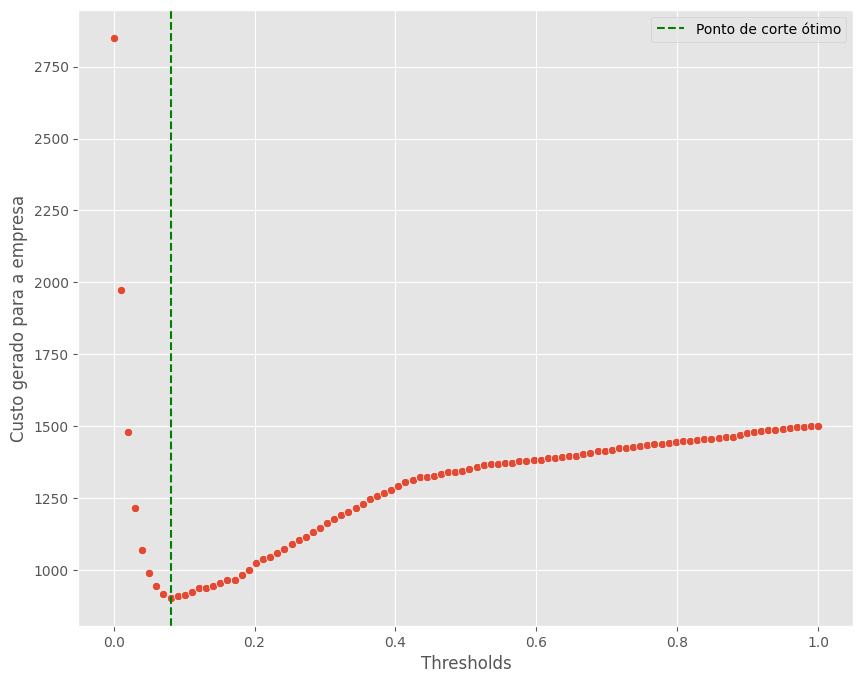

In [164]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = thresholds, y = costs);
min_cost = min(costs)
min_cost_index = costs.index(min(costs))
plt.axvline(x=thresholds[min_cost_index], color='g', linestyle='--', label='Ponto de corte ótimo')
plt.xlabel('Thresholds')
plt.ylabel('Custo gerado para a empresa')
plt.legend()
plt.show()